![alt text here](../web/coRe_logo.jpg)

# CoRe package benchmarking
This notebook contains the code for benchmarking core-fitness and common-essential genes (CFGs and CEGs) identified by the [CoRe R package](https://github.com/DepMap-Analytics/CoRe), respectively via the Adaptive Daisy Model (ADaM) and the Fitness Percentile (FiPer) method, against state-of-the-art sets of CFGs [1,2] and a logistic regression based method recently proposed in [3].<br>
All the tested methods are executed on the largest integrative dataset of cancer dependencies assembled to date and presented in [4]. This encompasses data from large scale CRISPR-Cas9 screens performed at the Wellcome Sanger Institute [5] (release 1) and the Broad Institute of MIT and Harvard ([DepMap.org](https://depmap.org/), Release 20Q2) across hundreds of human cancer cell lines from multiple tissues/cancer-types.<br>
This combined dataset is available at https://depmap.org/broad-sanger/ in two different versions resulting from two different preprocessing methods, respectively CERES [6] and CRISPRcleanR [7].<br>
As demonstrated in [4], the CERES processed version is more suited for the identification of CFGs, thus this version is used here. This dataset is also scaled as described in [6] using reference sets of prior known essential/non-essential genes [1] (manually curated as described in [5]), prior the execution of each tested method.

---


# Data derivation and preparation
Loading Libraries

In [1]:
options(warn=-1)

library(tidyverse)
library(pheatmap)
library(CoRe)
library(magrittr)
library(nVennR)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.3
✔ tibble  3.0.1     ✔ dplyr   1.0.2
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




Loading reference sets of essential/non-essential genes from [1] manually curated as described in [7], i.e. excluding 34 genes, such as for example KRAS and CHD4, predicted to be cancer drivers by the intOGen pipeline [8,9]. These are data objects built-in the CoRe package.


In [2]:
data('curated_BAGEL_essential')
data('curated_BAGEL_nonEssential')

Downloading the CERES processed integrated cancer dependency dataset introduced in [4] (~250MB, sit tight, this might take a bit).

In [3]:
url <- 'https://www.depmap.org/broad-sanger/integrated_Sanger_Broad_essentiality_matrices_20201201.zip'
temp <- tempfile()
download.file(url, temp, mode="wb") 
unzip(temp, exdir = 'integrated_dataset')
unlink(temp)

depFC <- read.table('integrated_dataset/integrated_Sanger_Broad_essentiality_matrices_20201201/CERES_FC.txt', 
                    row.names = 1, sep = '\t', header = TRUE, stringsAsFactors = FALSE, check.names = FALSE)
system('rm -r integrated_dataset')

print('CERES processed joint dataset of cancer dependencies correctly downloaded')


[1] "CERES processed joint dataset of cancer dependencies correctly downloaded"


Downloading cell line annotations from the Cell Model Passports [10] (2021-Mar-26 release), removing samples containing NAs and/or corresponding to not-annotated cell-lines, assigning cell-line names as column headers, scaling and deriving binary scores of gene essentiality.

In [4]:
## downloading cell lines' annotations
clannotation<-CoRe.download_AnnotationModel(URL='https://cog.sanger.ac.uk/cmp/download/model_list_20210326.csv')

## removing samples with NAs or not annotated
depFC <- depFC[,-which(is.na(colSums(depFC)))]
cells <- colnames(depFC)

tot_id <- clannotation %>% filter(model_id %in% cells | BROAD_ID %in% cells) %>% 
  select(model_name,model_id,BROAD_ID) %>% 
  pivot_longer(cols = c("model_id","BROAD_ID"), names_to = "institute", values_to = "model_id") %>% 
  select(model_name,model_id) %>% filter(model_id %in% cells) %>% 
  arrange(factor(model_id, levels = cells))

depFC <- depFC[,which(cells %in% tot_id$model_id)]

## assigning cell line names as column headers
colnames(depFC) <- tot_id$model_name

## scaling
scaled_depFC <- CoRe.scale_to_essentials(depFC,curated_BAGEL_essential,curated_BAGEL_nonEssential)

## deriving binary essentiality scores
bdep <- apply(scaled_depFC, 2, function(x){
  x[which(x >= -0.5)] <- 0
  x[which(x < -0.5)] <- 1
  x
})

print('Done: quantitative and binary dependency matrices have been created')
print(paste('(accounting for',dim(bdep)[1],'genes and',dim(bdep)[2],'cell lines'))


Parsed with column specification:
cols(
  .default = col_character(),
  pmed = col_double(),
  mutational_burden = col_double(),
  ploidy = col_double(),
  mutation_data = col_logical(),
  methylation_data = col_logical(),
  expression_data = col_logical(),
  cnv_data = col_logical(),
  crispr_ko_data = col_logical(),
  fusion_data = col_logical(),
  drug_data = col_logical(),
  rnaseq_data = col_logical(),
  age_at_sampling = col_double(),
  sampling_day = col_double(),
  sampling_month = col_double(),
  sampling_year = col_double()
)

See spec(...) for full column specifications.



[1] "Done: quantitative and binary dependency matrices have been created"
[1] "(accounting for 17486 genes and 855 cell lines"


# Computation of pan-cancer core-fitness genes with CoRe

## Executing ADaM at the pan-cancer level
ADaM is executed in the two step modality described in the manuscript, considering in the initial steps cancer tissues with dependency data for at least 15 cell lines, in turn.

In [5]:
## determining tissues with at least 15 cell lines in the dependency matrix
tissues_ctypes<-
  names(which(summary(as.factor(clannotation$tissue[match(colnames(bdep),clannotation$model_name)]))>=15))

print('ADaM will be executed at the tissue type level on the following tissue lineages:')
print(tissues_ctypes)

[1] "ADaM will be executed at the tissue type level on the following tissue lineages:"
 [1] "Biliary Tract"               "Bladder"                    
 [3] "Bone"                        "Breast"                     
 [5] "Central Nervous System"      "Endometrium"                
 [7] "Esophagus"                   "Haematopoietic and Lymphoid"
 [9] "Head and Neck"               "Kidney"                     
[11] "Large Intestine"             "Liver"                      
[13] "Lung"                        "Ovary"                      
[15] "Pancreas"                    "Peripheral Nervous System"  
[17] "Skin"                        "Soft Tissue"                
[19] "Stomach"                    


ADaM is executed at the pan-cancer level using the wrapper function built-in the CoRe package using the binary dependency matrix in input. This will take about 5mins on a common laptop. 

In [6]:
ADaM <- CoRe.PanCancer_ADaM(bdep,
                            tissues_ctypes,
                            clannotation = clannotation,
                            display=FALSE,
                            ntrials=1000,
                            verbose=FALSE,
                            TruePositives = curated_BAGEL_essential)

print(paste('Done: ADaM has identified',length(ADaM),'CFGs'))

## Executing the FiPer variants
All the variants of the FiPer method are executed on the quantitative cancer dependency matrix. A consensual set of predicted CEGs obtained by intersecting the output of the three less stringent variants is also assembled.

In [30]:
## FiPer with fixed strategy
Perc_fixed <- CoRe.FiPer(scaled_depFC,
                         display=FALSE,
                         method = 'fixed')$cfgenes

## FiPer with average strategy
Perc_avg <- CoRe.FiPer(scaled_depFC,
                       display=FALSE,
                       method = 'average')$cfgenes

## FiPer with slope strategy
Perc_slope <- CoRe.FiPer(scaled_depFC,
                         display=FALSE,
                         method = 'slope')$cfgenes

## Fiper with AUC strategy
Perc_AUC <- CoRe.FiPer(scaled_depFC,
                       display=FALSE,
                       method = 'AUC')$cfgenes

## consensual core-fitness genes across the three less stringent variants
Perc_Consensus <- Reduce(intersect,list(Perc_fixed,Perc_slope,Perc_AUC))

print('Done')

[1] "Done"


## Loading/Preparing state-of-the-art and obtained with a logistic regression method CFGs
 
The following state-of-the-art sets of CFGs are benchmarked: 

1. Hart2014
    + a set of 360 genes assembled by applying a linear algebra approach to a large collection of shRNA gene dependency profiles. This set is presented in [1] and it is used as a classification template by BAGEL: a supervised computational framework for quantifying  gene essentiality significance in pooled library screens [11,12];   
2. Hart2017
    + an expanded set of 684 genes obtained by reanalyzing with BAGEL 17 genome-scale knockout screens in human cell lines performed with different libraries, introduced in [2];<br>
3. Behan2019
    + a set of 553 genes presented in [5] and obtained by running ADaM on a large collection of gene dependency profiles from CRISPR-screens of 325 human cancer cell lines from different tissue-lineages/cancer-types (now part of the [Project Score](https://score.depmap.sanger.ac.uk/) database [13]), using a manually curated version of the Hart2014 set, as training. This was obtained by excluding from the Hart2014 set 34 genes, such as for example KRAS and CHD4, predicted to be cancer drivers by the intOGen pipeline [8,9];<br>
4. Sharma2020
    + a set of 519 genes presented in [3] and identified using a logistic regression approach (part of the CEN-tools software), which uses the BAGEL essential/never-essential genes as training, respectively the Hart2017 set and a set of 927 never-essential genes[11,12]. In [3], this approach was individually applied to the dependency profiles from [Project Score](https://score.depmap.sanger.ac.uk/)(Release 1) and from the [Broad DepMap portal]{https://depmap.org/portal/} (Release 19Q2). The final set was composed of genes predicted as CFGs in the two analyses and excluded those in the training set.<br>


In [31]:
## Hart2014 (built-in the CoRe package)
data(BAGEL_essential)
Hart_2014<-BAGEL_essential

## Hart2017
load('data/BAGEL_v2_ESSENTIAL_GENES.RData')
Hart_2017<-BAGEL_essential

## Behan2019
load('data/ADaM_CFs_Behan_et_Al_2019.RData')
Behan_2019<-PanCancerCoreFitnessGenes

## Sharma2020
Sharma_2020<-read.table(file = 'data/CenTools_essential_Sharma_et_al.txt',sep='\t',stringsAsFactors = FALSE)$V1

print(paste('Loaded',length(Hart_2014),'CFGs from Hart2014'))
print(paste('Loaded',length(Hart_2017),'CFGs from Hart2017'))
print(paste('Loaded',length(Behan_2019),'CFGs from Behan2019'))
print(paste('Loaded',length(Sharma_2020),'CFGs from Sharma2020'))



[1] "Loaded 360 CFGs from Hart2014"
[1] "Loaded 684 CFGs from Hart2017"
[1] "Loaded 553 CFGs from Behan2019"
[1] "Loaded 519 CFGs from Sharma2020"


<span style="color: red;">Essential genes obtained with the Logistic Regression based method part of the CEN-tools software (Alessandro please amend this and the code below).</span>

In [32]:
## Essentials genes obtained with CENtools using BAGEL curated genes as reference sets (default nº bin = 20)
load('data/CENtools_Essentials.RData')

## CENtools
CENtools <- CENtools_ess

print(paste('Computed',length(CENtools),'CFGs via the logistic regression based method (part of CEN-tools)'))

[1] "Computed 755 CFGs via the logistic regression based method (part of CEN-tools)"


Assembling all CFGs in a unique list and creating a vector of colors to be used in the plots

In [38]:
## Assembling all CFGs in a unique list and creating a vector of colors to be used in the plots
CFs_sets<-list(Hart_2014,
               Hart_2017,
               Behan_2019,
               Sharma_2020,
               CENtools,
               ADaM,
               Perc_avg,
               Perc_Consensus,
               Perc_slope,
               Perc_AUC,
               Perc_fixed)

names(CFs_sets)<-c('Hart 2014',
                   'Hart 2017',
                   'ADaM (Behan 2019)',
                   'CEN-tools (Sharma 2020)',
                   'CEN-tools',
                   'ADaM',
                   'FiPer Average',
                   'FiPer Consensual',
                   'FiPer Slope',
                   'FiPer AUC',
                   'FiPer Fixed')

col=c("#03B2C8","#034DD9","#E6AB02","#1B9E77","#337100","#FC8D62",
      '#F4CAE4','#800080','#CAB2D6','#BEBADA','#777892')
names(col)<-names(CFs_sets)


Assembling a set of genes included in one of the sets used as training set by at least one method

In [34]:
TrainingSets<-unique(c(BAGEL_essential,
                       BAGEL_nonEssential,
                       curated_BAGEL_essential,
                       curated_BAGEL_nonEssential))

print(paste(length(TrainingSets),'genes used for training by at least one method'))

[1] "1771 genes used for training by at least one method"


Creating a list of putative novel CFGs by removing the training genes from the sets of predicted CFGs

In [35]:
novelCFs_sets<-lapply(CFs_sets,function(x){
  setdiff(x,TrainingSets)
})

Comparing and plotting CFG sets' sizes.

[1] "novel hits:"
              FiPer AUC             FiPer Fixed             FiPer Slope 
                   1262                    1227                    1003 
       FiPer Consensual           FiPer Average                    ADaM 
                    975                     743                     460 
CEN-tools (Sharma 2020)               CEN-tools       ADaM (Behan 2019) 
                    441                     378                     157 
              Hart 2014               Hart 2017 
                     17                       0 
[1] "Unsupervised method all hits:"
FiPer Average   FiPer Slope     FiPer AUC   FiPer Fixed 
         1424          1704          1987          1947 
[1] 1825.5
[1] "Unsupervised method novel hits:"
FiPer Average   FiPer Slope     FiPer AUC   FiPer Fixed 
          743          1003          1262          1227 
[1] 1115
[1] "FiPer consensual n.genes (total):  1673"
[1] "FiPer consensual n.genes (novel hits): 975"


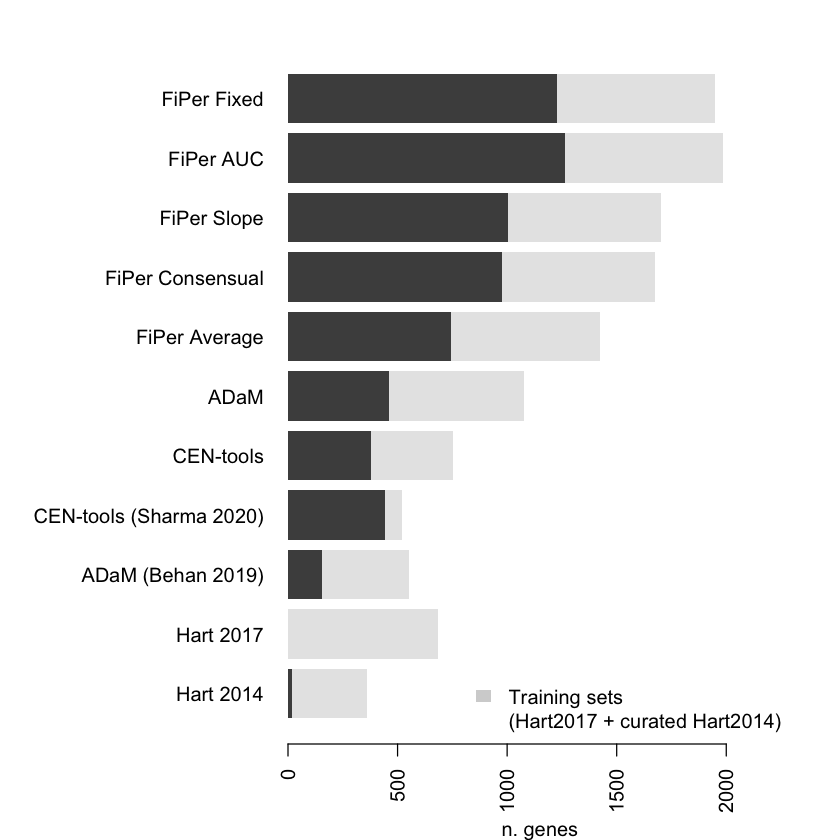

In [37]:
GeneLengths<-unlist(lapply(CFs_sets,length))
novelGeneLengths<-unlist(lapply(novelCFs_sets,length))

print('novel hits:')
print(sort(novelGeneLengths,decreasing=TRUE))

print('Unsupervised method all hits:')
print(GeneLengths[c('FiPer Average','FiPer Slope','FiPer AUC','FiPer Fixed')])
print(median(GeneLengths[c('FiPer Average','FiPer Slope','FiPer AUC','FiPer Fixed')]))

print('Unsupervised method novel hits:')
print(novelGeneLengths[c('FiPer Average','FiPer Slope','FiPer AUC','FiPer Fixed')])
print(median(novelGeneLengths[c('FiPer Average','FiPer Slope','FiPer AUC','FiPer Fixed')]))

print(paste('FiPer consensual n.genes (total): ',length(CFs_sets$`FiPer Consensual`)))
print(paste('FiPer consensual n.genes (novel hits):',length(novelCFs_sets$`FiPer Consensual`)))

par(mar=c(4,12,2,2))
barplot(rbind(novelGeneLengths,GeneLengths-novelGeneLengths),
        las=2,border = FALSE,horiz = TRUE,xlim=c(0,2300),
        xlab='n. genes')

legend('bottomright',legend = c('Training sets','(Hart2017 + curated Hart2014)'),
       fill=c('lightgray',NA),border=NA,bty = 'n')


Computing Recall rates of state-of-the-art sets of CFGs.

[1] "ADaM median Recall across prior known sets: 77.2453774127032"
[1] "FiPer median Recall across prior known sets avg across variants: 89.3199562221082"


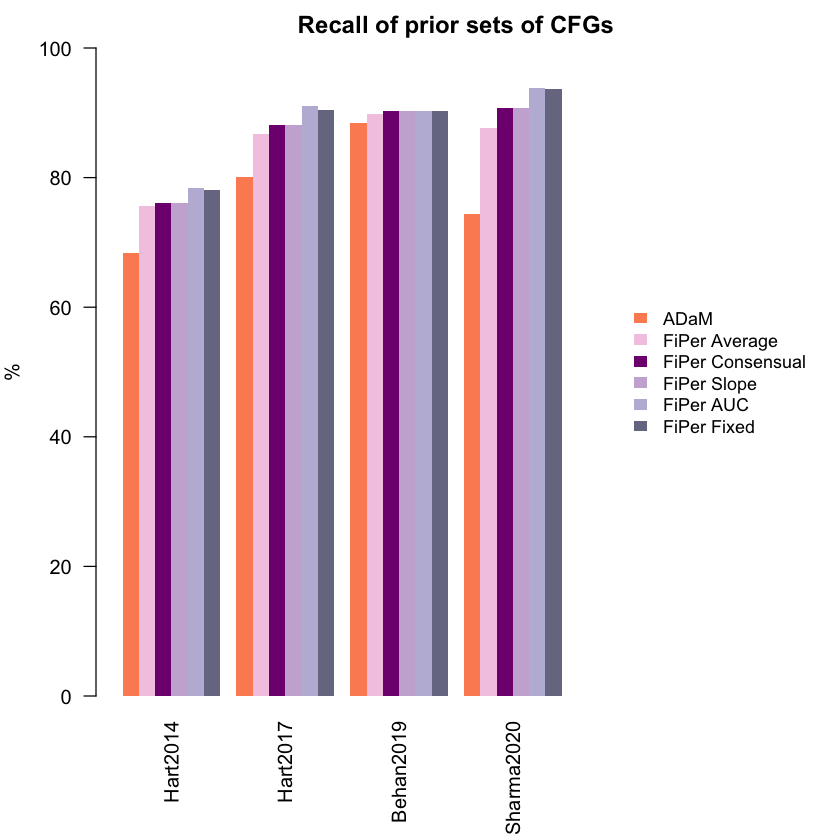

In [47]:
Recall_Hart2014<-unlist(lapply(CFs_sets,function(x){
  100*length(intersect(x,CFs_sets$`Hart 2014`))/length(CFs_sets$`Hart 2014`)
}))

Recall_Hart2017<-unlist(lapply(CFs_sets,function(x){
  100*length(intersect(x,CFs_sets$`Hart 2017`))/length(CFs_sets$`Hart 2017`)
}))

Recall_Behan2019<-unlist(lapply(CFs_sets,function(x){
  100*length(intersect(x,CFs_sets$`ADaM (Behan 2019)`))/length(CFs_sets$`ADaM (Behan 2019)`)
}))

Recall_Sharma2020<-unlist(lapply(CFs_sets,function(x){
  100*length(intersect(x,CFs_sets$`CEN-tools (Sharma 2020)`))/length(CFs_sets$`CEN-tools (Sharma 2020)`)
}))



Recalls<-rbind(Recall_Hart2014[6:11],Recall_Hart2017[6:11],Recall_Behan2019[6:11],Recall_Sharma2020[6:11])
rownames(Recalls)<-c('Hart2014','Hart2017','Behan2019','Sharma2020')
## creating some space for displaying the legend 
Recalls<-rbind(Recalls,rep(NA,6))
Recalls<-rbind(Recalls,rep(NA,6))


par(mar=c(6,4,2,1))
barplot(t(Recalls),beside = TRUE,col=col[names(CFs_sets)[6:11]],ylim=c(0,100),ylab='%',
        border=FALSE,main='Recall of prior sets of CFGs',las=2)
legend('right',names(CFs_sets)[6:11],cex=0.9,fill=col[names(CFs_sets)[6:11]],border=NA,bty = 'n')

print(paste('ADaM median Recall across prior known sets:',median(Recalls[,'ADaM'],na.rm = TRUE)))
print(paste('FiPer median Recall across prior known sets avg across variants:',
            mean(apply(Recalls[,2:6],MARGIN = 2,median,na.rm = TRUE))))


Adding training sets to Sharma2020 and CENtools predictions to explore overall sets similarities

In [49]:
CFs_sets_plus_training<-CFs_sets
CFs_sets_plus_training$`CEN-tools (Sharma 2020)`<-
  union(CFs_sets_plus_training$`CEN-tools (Sharma 2020)`,BAGEL_essential)

CFs_sets_plus_training$`CEN-tools`<-
  union(CFs_sets_plus_training$`CEN-tools`,curated_BAGEL_essential)

<span style="color: red;">Please do not work over this point</span>

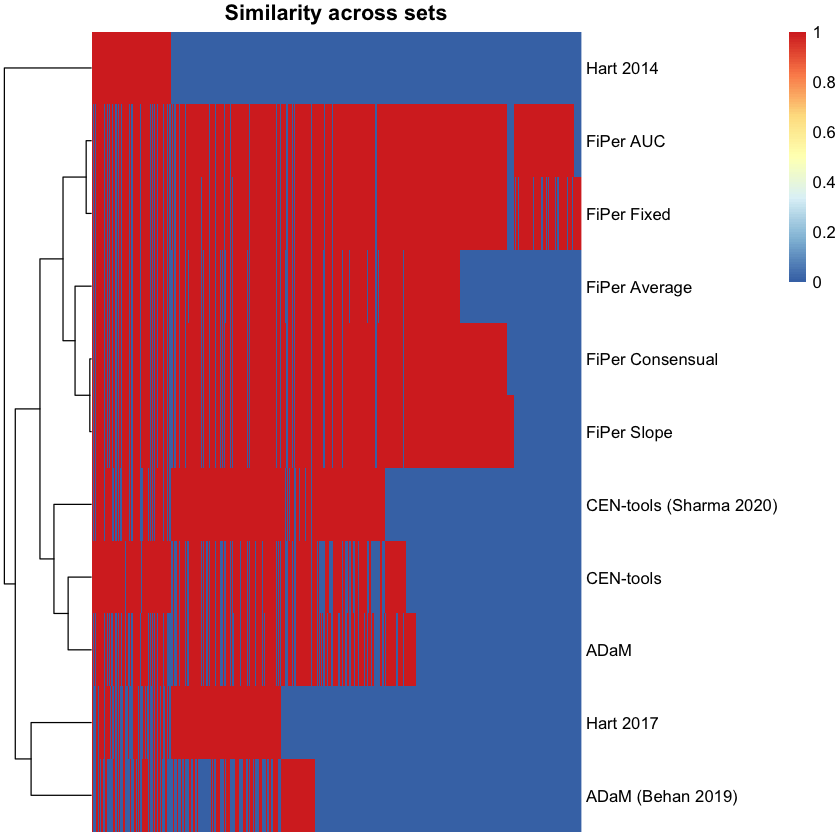

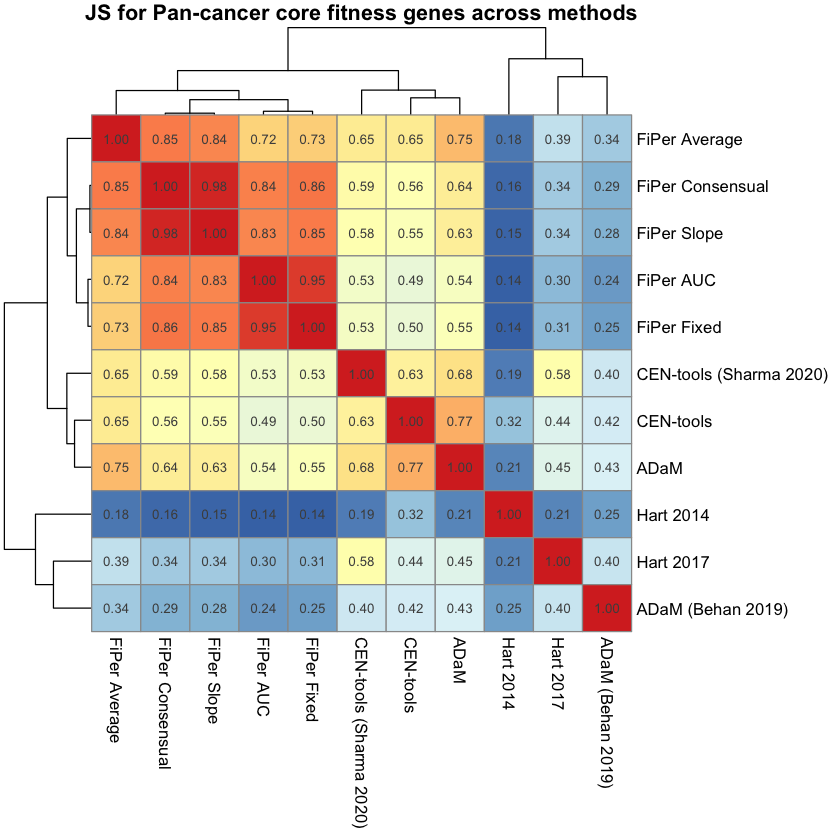

In [50]:
##### CF gene set similarity
allEss<-unique(unlist(CFs_sets_plus_training))
membMat<-do.call(rbind,lapply(CFs_sets_plus_training,function(x){is.element(allEss,x)}))
rownames(membMat)<-names(CFs_sets)
colnames(membMat)<-allEss
membMat<-membMat+0

pheatmap(membMat,show_colnames = FALSE,clustering_distance_rows = 'binary',cluster_cols = FALSE,border_color = NA,
         main = 'Similarity across sets')

dmat<-dist(membMat,method = 'binary')

pheatmap(1-as.matrix(dmat), main = 'JS for Pan-cancer core fitness genes across methods', 
         legend = FALSE,display_numbers = round(dmat,digits = 2))

## Baseline predictor

A baseline predictor is defined by considering CF genes those essential in at least n cell lines for all n. We compute the recall of this predictor using independent sets of a priori known essential genes (i.e. those involved in housekeeping cellular processes like translation or replication) [1-2]. <br>
In addition, gene dependencies associated with a biomarker are very specific to the molecular context, therefore, these genes classified as CF are deemed false positives (FP). In the FP set are included also the non-expressed genes. We compute the recall of these FP genes for the baseline predictor.

__References__ <br>
[1]	F. Iorio et al., “Unsupervised correction of gene-independent cell responses to CRISPR-Cas9 targeting,” BMC Genomics, 2018, doi: 10.1186/s12864-018-4989-y. <br>
[2]	C. Pacini et al., “Integrated cross-study datasets of genetic dependencies in cancer,” Nat. Commun., vol. 12, no. 1, p. 1661, 2021, doi: 10.1038/s41467-021-21898-7.

In [ ]:
##### Ability to identify novel hits
CFs_sets<-list(Behan_2019 = ADaM_2019,
               Sharma_2020 = CENtools_2020,
               CENtools = CENtools_SV1_B20Q2_CERES,
               ADaM = ADaM,
               F_Perc_avg = Perc_avg,
               F_Perc_Cons_lax = Perc_Consensus,
               F_Perc_slope = Perc_slope,
               F_Perc_AUC = Perc_AUC,
               F_Perc_fixed = Perc_fixed)

## Assembling a set of prior known essential genes that are not included in the
## training sets used by CENtools and/or ADaM
data(EssGenes.DNA_REPLICATION_cons)
data(EssGenes.KEGG_rna_polymerase)
data(EssGenes.PROTEASOME_cons)
data(EssGenes.SPLICEOSOME_cons)
data(EssGenes.ribosomalProteins)
data(EssGenes.HISTONES)

signatures<-list(DNA_REPLICATION=EssGenes.DNA_REPLICATION_cons,
                 RNA_POLYMERASE=EssGenes.KEGG_rna_polymerase,
                 PROTEASOME=EssGenes.PROTEASOME_cons,
                 SPLICEOSOME=EssGenes.SPLICEOSOME_cons,
                 RIBOSOMAL_PROTS=EssGenes.ribosomalProteins,
                 HISTONES=EssGenes.HISTONES)

signatures<-unique(unlist(signatures))

geneSet <- rownames(scaled_depFC)

## Adding additional signatures in Pacini et al, 2020
load("data/Kegg.DNArep.Rdata")
load("data/Kegg.Ribosome.Rdata")
load("data/Kegg.Proteasome.Rdata")
load("data/Kegg.Spliceosome.Rdata")
load("data/Kegg.RNApoly.Rdata")
load("data/Histones.Rdata")

allRefEss<-unique(c(Kegg.DNArep,Kegg.Proteasome,Kegg.Ribosome,Kegg.RNApoly,Kegg.Spliceosome,Histones))

signatures<-union(signatures,allRefEss)
signatures <- intersect(signatures,geneSet)

## training sets used by ADaM/CENtools while executed on the new joint dataset
## and by ADaM on the old dataset
BAG_genes <- unique(c(curated_BAGEL_essential,
                      curated_BAGEL_nonEssential,
                      BAGEL_essential,
                      BAGEL_nonEssential))

## removing training sets used by ADaM/CENtools while executed on the new joint dataset
## and by ADaM on the old dataset
signatures <- setdiff(signatures,BAG_genes)
geneSet_noBAG <- setdiff(geneSet,BAG_genes)

## baseline predictor
baselineCFs <- lapply(1:ncol(bdep),function(x){
  names(which(rowSums(bdep)>=x))
})

baselineSizes<-unlist(lapply(baselineCFs,length))

baselineRecalls<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,signatures))/length(signatures)
}))

load('data/CMP_RNAseq.Rdata')

## genes not expressed
lowlyExp<-names(which(rowSums(CMP_RNAseq<0.01,na.rm=TRUE)>=ncol(CMP_RNAseq)))

## dependency associated with biomarkers
FPs <- sort(unique(unlist(read.table('data/dependency_with_biomarkers.txt',stringsAsFactors = FALSE))))
FPs <- union(FPs,lowlyExp)
FPs <- intersect(FPs,geneSet_noBAG)

baselineNEratio<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,FPs))/length(FPs)
}))

plot(baselineSizes,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)', 
     ylab='n. of predicted CF genes',pch=16,log='y',main = 'BAGEL genes removed')

plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes not used for training',pch=16)

plot(baselineNEratio,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of FP genes (associated with a biomarker or lowly expressed)',pch=16)

## Comparison between method considering novel hits

The metrics derived from the baseline predictors are then used to assess the CF sets predicted by each method. We consider the CF sets without the BAGEL genes used for the training of CEN-tools, namely BAGEL essential version 2 and non-essential used for Sharma_2020 set, and curated BAGEL essential and non-essential used for CENtools set. <br>
In the first plot, we normalised the recall of the signatures by the maximum recall achieved by the baseline predictor. The 90-th percentile variants have a higher ratio since they are less stringent. <br>
In the second plot, we show the recall ratio of the FP genes. ADaM and CEN-tools tend to show a higher stringency than the 90-th percentile variants, though the 'average' variant ratio is close to the ADaM and CEN-tools sets. <br>

In [ ]:
fCFs_sets <- lapply(CFs_sets,function(x){
  setdiff(x,BAG_genes)
})

observed_recalls<-100*unlist(lapply(fCFs_sets,
                                    function(x){length(intersect(x,signatures))/length(signatures)}))

observed_FPs<-100*unlist(lapply(fCFs_sets,
                                function(x){length(intersect(x,FPs))/length(FPs)}))

par(mar=c(8,6,4,4))
barplot(observed_recalls/max(baselineRecalls),col=col[names(observed_recalls)],
        las=2,ylab='Recall / (max Recall)',border=NA,main = 'Prior known essential not included in training')

barplot(observed_FPs/max(baselineNEratio),col=col[names(observed_FPs)],
        las=2,ylab='Recall / (max Recall)', border=NA, main = 'False positive CFs')

However, in order to have a fair comparison between the methods, we need to compare both the recall of prior known essential genes (from here on referred as true positive, TP) and the recall of FP genes to the baseline predictor. To do so we draw the relationship between TP and FP genes for the baseline predictor and show where each method stand. This approach shows that the 90-th percentile variants are more stringent than CEN-tools and ADaM when the size of predicted CF genes is taken into account.

In [ ]:
plot(spline(baselineRecalls,baselineNEratio),pch=16,
     xlab='% Recall of prior known essentials',
     ylab='% Recall of selective essentials (associated with a biomarker)',type='l',lwd=4,
     xlim=c(10,50),ylim=c(0,6))

points(observed_recalls,observed_FPs,col=col[names(observed_FPs)],pch=16,cex=2)

s0fun<-splinefun(baselineRecalls,baselineNEratio)

par(mar=c(8,6,4,4))
barplot(observed_FPs/s0fun(observed_recalls),col=col[names(observed_FPs)],
        las=2,border=NA,ylab='False CFs at fixed Recall of TPs / baseline')
abline(h=1,lty=2)

In the first plot, we show the threshold required by the baseline classifier to attain the observed recalls for each method. Although the 90-th percentile variants have lower threshold, they score higher when considering the median dependent cell lines of their CFs compared to the baseline classifier as shown in the second plot. This means that the predicted CF genes tend to be essential in a larger number of cell lines compared to CEN-tools and ADaM.

In [ ]:
baselineRecalls<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,signatures))/length(signatures)
}))

par(mar=c(8,6,4,2))
plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes not used for training',pch=16)

s0fun<-splinefun(baselineRecalls,1:length(baselineRecalls))
abline(v=s0fun(observed_recalls),col=col[names(observed_recalls)],lwd=2)

baseline_dep_cell_lines<-s0fun(observed_recalls)

median_n_dependent_cell_lines<-
  unlist(lapply(fCFs_sets,function(x){median(rowSums(bdep[intersect(x,geneSet),]))}))

barplot(median_n_dependent_cell_lines/baseline_dep_cell_lines,col=col[names(median_n_dependent_cell_lines)],
        las=2, border=NA,main = 'Median dependent cell lines on the CFs / baseline', ylab = 'ratio')
abline(h=1,lty=2)

In the first plot, we show the median fitness effect of the CF genes predicted by each method relative to the baseline predictor. CF genes predicted by the 90-th percentile variants have higher fitness score compared to ADaM and CEN-tools. This can be explained by the lower stringency of these methods that include genes with higher fitness score, therefore diluting the signal. <br>
In the second plot, we show the number of CF genes for each method compared to the baseline predictor.

In [ ]:
observed_sizes<-lapply(CFs_sets,length)

median_dep <- unlist(lapply(CFs_sets,
                function(x){median(apply(scaled_depFC[intersect(x,geneSet_noBAG),],1,median))}))

baseline_dep <- unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],
                function(x){median(apply(scaled_depFC[intersect(x,geneSet_noBAG),],1,median))}))

par(mar=c(8,6,4,2))
barplot(median_dep/baseline_dep,col=col[names(median_dep)],
        las=2,main = 'Median CFs fitness effect / baseline', border=NA, ylab = 'ratio')
abline(h=1,lty=2)

baseline_size<-unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],length))
observed_sizes<-unlist(observed_sizes)

barplot(observed_sizes/baseline_size,col=col[names(observed_sizes)],
        las=2,main = 'n. CFs / baseline',border=NA, ylab = 'ratio')
abline(h=1,lty=2)

## Comparison between methods accounting for BAGEL genes
We perform the same pipeline shown above, but this time including the BAGEL gene sets used in the training phase of CEN-tools sets.

In [ ]:
## Essentials genes obtained with CENtools using BAGEL curated genes as reference sets (default nº bin = 20)
load('data/CENtools_Essentials.RData')

## CENtools
data(curated_BAGEL_essential)
CENtools_SV1_B20Q2_CERES <- c(CENtools_ess, curated_BAGEL_essential)

## CENtools Sharma et al, 2020
load('data/BAGEL_v2_Essentials.RData')
CENtools_2020 <- read.table(file = 'data/CenTools_essential_Sharma_et_al.txt',sep='\t',stringsAsFactors = FALSE)$V1
CENtools_2020 <- c(CENtools_2020, BAGEL_essential)

## ADaM essential Behan et al., 2019
load('data/ADaM_CFs_Behan_et_Al_2019.RData')
ADaM_2019<-PanCancerCoreFitnessGenes

col=c("#03B2C8","#034DD9","#E6AB02","#1B9E77","#337100","#FC8D62",'black',
      "#F4CAE4",'purple',"#CAB2D6","#BEBADA","#777892")
names(col) <- c("Hart_2015","Hart_2017","Behan_2019","Sharma_2020","CENtools","ADaM",
              "F_Perc_Cons","F_Perc_avg","F_Perc_Cons_lax","F_Perc_slope","F_Perc_AUC","F_Perc_fixed")

##### Ability to identify novel hits
CFs_sets<-list(Behan_2019 = ADaM_2019,
               Sharma_2020 = CENtools_2020,
               CENtools = CENtools_SV1_B20Q2_CERES,
               ADaM = ADaM,
               F_Perc_avg = Perc_avg,
               F_Perc_Cons_lax = Perc_Consensus,
               F_Perc_slope = Perc_slope,
               F_Perc_AUC = Perc_AUC,
               F_Perc_fixed = Perc_fixed)

## Assembling a set of prior known essential genes that are not included in the
## training sets used by CENtools and/or ADaM
signatures<-list(DNA_REPLICATION=EssGenes.DNA_REPLICATION_cons,
                 RNA_POLYMERASE=EssGenes.KEGG_rna_polymerase,
                 PROTEASOME=EssGenes.PROTEASOME_cons,
                 SPLICEOSOME=EssGenes.SPLICEOSOME_cons,
                 RIBOSOMAL_PROTS=EssGenes.ribosomalProteins,
                 HISTONES=EssGenes.HISTONES)

signatures<-unique(unlist(signatures))

## Adding additional signatures in Pacini et al, 2020
allRefEss<-unique(c(Kegg.DNArep,Kegg.Proteasome,Kegg.Ribosome,Kegg.RNApoly,Kegg.Spliceosome,Histones))

signatures<-union(signatures,allRefEss)
signatures <- intersect(signatures,geneSet)

## baseline predictor
baselineCFs <- lapply(1:ncol(bdep),function(x){
  names(which(rowSums(bdep)>=x))
})

baselineSizes<-unlist(lapply(baselineCFs,length))

baselineRecalls<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,signatures))/length(signatures)
}))

## genes not expressed
lowlyExp<-names(which(rowSums(CMP_RNAseq<0.01,na.rm=TRUE)>=ncol(CMP_RNAseq)))

## dependency associated with biomarkers
FPs <- sort(unique(unlist(read.table('data/dependency_with_biomarkers.txt',stringsAsFactors = FALSE))))
FPs <- union(FPs,lowlyExp)
FPs <- intersect(FPs,geneSet_noBAG)

baselineNEratio<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,FPs))/length(FPs)
}))

plot(baselineSizes,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)', 
     ylab='n. of predicted CF genes',pch=16,log='y', main = "BAGEL genes included")

plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes not used for training',pch=16)

plot(baselineNEratio,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of selective essentials (associated with a biomarker)',pch=16)

In [ ]:
fCFs_sets <- CFs_sets

observed_recalls<-100*unlist(lapply(fCFs_sets,
                                    function(x){length(intersect(x,signatures))/length(signatures)}))

observed_FPs<-100*unlist(lapply(fCFs_sets,
                                function(x){length(intersect(x,FPs))/length(FPs)}))

par(mar=c(8,6,4,4))
barplot(observed_recalls/max(baselineRecalls),col=col[names(observed_recalls)],
        las=2,ylab='Recall / (max Recall)',border=NA,main = 'Prior known essential with training genes included')

barplot(observed_FPs/max(baselineNEratio),col=col[names(observed_FPs)],
        las=2,ylab='Recall / (max Recall)', border=NA, main = 'False positive CFs')

In [ ]:
plot(spline(baselineRecalls,baselineNEratio),pch=16,
     xlab='% Recall of prior known essentials',
     ylab='% Recall of selective essentials (associated with a biomarker)',type='l',lwd=4,
     xlim=c(40,70),ylim=c(0,6))

points(observed_recalls,observed_FPs,col=col[names(observed_FPs)],pch=16,cex=2)

s0fun<-splinefun(baselineRecalls,baselineNEratio)

par(mar=c(8,6,4,4))
barplot(observed_FPs/s0fun(observed_recalls),col=col[names(observed_FPs)],
        las=2,border=NA,ylab='False CFs at fixed Recall of TPs / baseline')
abline(h=1,lty=2)

In [ ]:
baselineRecalls<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,signatures))/length(signatures)
}))

par(mar=c(8,6,4,2))
plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes',pch=16)

s0fun<-splinefun(baselineRecalls,1:length(baselineRecalls))
abline(v=s0fun(observed_recalls),col=col[names(observed_recalls)],lwd=2)

baseline_dep_cell_lines<-s0fun(observed_recalls)

median_n_dependent_cell_lines<-
  unlist(lapply(fCFs_sets,function(x){median(rowSums(bdep[intersect(x,geneSet),]))}))

barplot(median_n_dependent_cell_lines/baseline_dep_cell_lines,col=col[names(median_n_dependent_cell_lines)],
        las=2, border=NA,main = 'Median dependent cell lines on the CFs / baseline', ylab = 'ratio')
abline(h=1,lty=2)

In [ ]:
observed_sizes<-lapply(CFs_sets,length)

median_dep <- unlist(lapply(CFs_sets,
                function(x){median(apply(scaled_depFC[intersect(x,geneSet),],1,median))}))

baseline_dep <- unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],
                function(x){median(apply(scaled_depFC[intersect(x,geneSet),],1,median))}))

par(mar=c(8,6,4,2))
barplot(median_dep/baseline_dep,col=col[names(median_dep)],
        las=2,main = 'Median CFs fitness effect / baseline', border=NA, ylab = 'ratio')
abline(h=1,lty=2)

baseline_size<-unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],length))
observed_sizes<-unlist(observed_sizes)

barplot(observed_sizes/baseline_size,col=col[names(observed_sizes)],
        las=2,main = 'n. CFs / baseline',border=NA, ylab = 'ratio')
abline(h=1,lty=2)


---

__References__ <br>

[1] Hart T, Brown KR, Sircoulomb F, Rottapel R, Moffat J. Measuring error rates in genomic perturbation screens: gold standards for human functional genomics. Mol Syst Biol. 2014;10:733.<br>
[2] Hart T, Tong AHY, Chan K, Van Leeuwen J, Seetharaman A, Aregger M, et al. Evaluation and Design of Genome-Wide CRISPR/SpCas9 Knockout Screens. G3. 2017;7:2719–27.<br>
[3] Sharma S, Dincer C, Weidemüller P, Wright GJ, Petsalaki E. CEN-tools: an integrative platform to identify the contexts of essential genes. Mol Syst Biol. 2020;16:e9698.<br>
[4] Pacini C, Dempster JM, Boyle I, Gonçalves E, Najgebauer H, Karakoc E, et al. Integrated cross-study datasets of genetic dependencies in cancer. Nat Commun. 2021;12:1661.<br>
[5] Behan FM, Iorio F, Picco G, Gonçalves E, Beaver CM, Migliardi G, et al. Prioritization of cancer therapeutic targets using CRISPR-Cas9 screens. Nature. 2019;568:511–6.<br>
[6] Meyers RM, Bryan JG, McFarland JM, Weir BA, Sizemore AE, Xu H, et al. Computational correction of copy number effect improves specificity of CRISPR–Cas9 essentiality screens in cancer cells. Nat Genet. 2017;49:1779–84.<br>
[7] Iorio F, Behan FM, Gonçalves E, Bhosle SG, Chen E, Shepherd R, et al. Unsupervised correction of gene-independent cell responses to CRISPR-Cas9 targeting. BMC Genomics. 2018;19:604.<br>
[8] Iorio F, Knijnenburg TA, Vis DJ, Bignell GR, Menden MP, Schubert M, et al. A Landscape of Pharmacogenomic Interactions in Cancer. Cell. 2016;166:740–54.<br>
[9] Martínez-Jiménez F, Muiños F, Sentís I, Deu-Pons J, Reyes-Salazar I, Arnedo-Pac C, et al. A compendium of mutational cancer driver genes. Nat Rev Cancer. 2020;20:555–72.<br>
[10] van der Meer D, Barthorpe S, Yang W, Lightfoot H, Hall C, Gilbert J, et al. Cell Model Passports—a hub for clinical, genetic and functional datasets of preclinical cancer models. Nucleic Acids Res. 2019;47:D923–9.
[11] Hart T, Chandrashekhar M, Aregger M, Steinhart Z, Brown KR, MacLeod G, et al. High-Resolution CRISPR Screens Reveal Fitness Genes and Genotype-Specific Cancer Liabilities. Cell. 2015;163:1515–26.
[12] Hart T, Moffat J. BAGEL: a computational framework for identifying essential genes from pooled library screens. BMC Bioinformatics. 2016;17:164.
[13] Dwane L, Behan FM, Gonçalves E, Lightfoot H, Yang W, van der Meer D, et al. Project Score database: a resource for investigating cancer cell dependencies and prioritizing therapeutic targets. Nucleic Acids Res. 2021;49:D1365–72.